In [ ]:
# !pip install khmer-nltk
# !pip install nltk

Defaulting to user installation because normal site-packages is not writeable
  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   --- ------------------------------------ 0.5/7.0 MB 6.4 MB/s eta 0:00:02
   --------- ------------------------------ 1.6/7.0 MB 6.2 MB/s eta 0:00:01
   ------------------ --------------------- 3.1/7.0 MB 5.8 MB/s eta 0:00:01
   ------------------------- -------------- 4.5/7.0 MB 5.9 MB/s eta 0:00:01
   ---------------------------- ----------- 5.0/7.0 MB 5.8 MB/s eta 0:00:01
   ---------------------------------- ----- 6.0/7.0 MB 5.3 MB/s eta 0:00:01
   ---------------------------------------- 7.0/7.0 MB 5.2 MB/s  0:00:01
Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)

   ---------------------------------------- 0/4 [tabulate]
   ---------------------------------------- 0/4 [tabulate]
   ---------- ----------------------------- 1/4 [python-crfsuite]
   -------------------

In [46]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scipy.sparse import save_npz
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from joblib import load, dump
import joblib

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

In [47]:
train_df = pd.read_csv('../BOW_PROJECT/tokenized/khmer_news_train_tokenized.csv', encoding='utf-8-sig')
val_df   = pd.read_csv('../BOW_PROJECT/tokenized/khmer_news_val_tokenized.csv', encoding=' utf-8-sig')
test_df  = pd.read_csv('../BOW_PROJECT/tokenized/khmer_news_test_tokenized.csv', encoding='utf-8-sig')

In [48]:
print(f"  - train_tokenized.csv ({len(train_df)} samples)")
print(f"  - val_tokenized.csv ({len(val_df)} samples)")
print(f"  - test_tokenized.csv ({len(test_df)} samples)")

  - train_tokenized.csv (5140 samples)
  - val_tokenized.csv (661 samples)
  - test_tokenized.csv (1543 samples)


## Bow Model

In [49]:
def build_and_save_bow(train_df, val_df, test_df, 
                       output_prefix="bow",
                       max_features=9000, min_df=2, max_df=0.85, ngram_range=(1,2)):
    """
    Build Bag-of-Words matrices from tokenized text and save vectorizer, matrices, and labels.

    Args:
        train_df, val_df, test_df (pd.DataFrame): dataframes with 'content' & 'label'
        output_prefix (str): prefix for saved files
        max_features (int): max vocabulary size
        min_df (int): ignore words in fewer than min_df docs
        max_df (float): ignore words in more than max_df proportion of docs
        ngram_range (tuple): ngram range, e.g., (1,2)
    
    Returns:
        count_vec: fitted CountVectorizer
        X_train, X_val, X_test: sparse BoW matrices
        y_train, y_val, y_test: label arrays
    """
    
    # -----------------------------
    # 1. Initialize CountVectorizer
    # -----------------------------
    count_vec = CountVectorizer(
        analyzer=str.split,       # split by space since text is already tokenized
        max_features=max_features,
        min_df=min_df,
        max_df=max_df,
        ngram_range=ngram_range
    )
    
    # -----------------------------
    # 2. Fit transform train, transform val/test
    # -----------------------------
    X_train_bow = count_vec.fit_transform(train_df['content'])
    X_val_bow   = count_vec.transform(val_df['content'])
    X_test_bow  = count_vec.transform(test_df['content'])
    
    # Labels
    y_train = train_df['label'].values
    y_val   = val_df['label'].values
    y_test  = test_df['label'].values
    
    # -----------------------------
    # 3. Save vectorizer
    # -----------------------------
    joblib.dump(count_vec, f"{output_prefix}_vectorizer.pkl")
    
    # -----------------------------
    # 4. Save BoW matrices
    # -----------------------------
    save_npz(f"{output_prefix}_train.npz", X_train_bow)
    save_npz(f"{output_prefix}_val.npz", X_val_bow)
    save_npz(f"{output_prefix}_test.npz", X_test_bow)
    
    # -----------------------------
    # 5. Save labels
    # -----------------------------
    pd.DataFrame(y_train, columns=["label"]).to_csv(f"{output_prefix}_train_labels.csv", index=False)
    pd.DataFrame(y_val, columns=["label"]).to_csv(f"{output_prefix}_val_labels.csv", index=False)
    pd.DataFrame(y_test, columns=["label"]).to_csv(f"{output_prefix}_test_labels.csv", index=False)
    
    print("✅ BoW vectorizer, matrices, and labels saved successfully!")
    
    return count_vec, X_train_bow, X_val_bow, X_test_bow, y_train, y_val, y_test

# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":

    # Run BoW pipeline
    vectorizer, X_train_bow, X_val_bow, X_test_bow, y_train, y_val, y_test = build_and_save_bow(
        train_df, val_df, test_df, output_prefix="khmer_news_bow"
    )


C:\Users\Kimlang\AppData\Roaming\Python\Python314\site-packages\sklearn\feature_extraction\text.py:533: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(


✅ BoW vectorizer, matrices, and labels saved successfully!


In [50]:
from scipy.sparse import load_npz

# Print type and shape
print("Type:", type(X_train_bow))
print("Shape:", X_train_bow.shape)
print("Number of non-zero entries:", X_train_bow.nnz)

Type: <class 'scipy.sparse._csr.csr_matrix'>
Shape: (5140, 9000)
Number of non-zero entries: 777533


In [45]:
import joblib

# Load vectorizer
vectorizer = joblib.load("../BOW_PROJECT/Bow_approach/khmer_news_bow_vectorizer.pkl")

# Check type
print("Type:", type(vectorizer))

# Vocabulary size
print("Vocabulary size:", len(vectorizer.vocabulary_))

# See first 10 words and their column indices
print(list(vectorizer.vocabulary_.items())[:10])

Type: <class 'sklearn.feature_extraction.text.CountVectorizer'>
Vocabulary size: 9000
[('ភ្នំពេញ', np.int64(6281)), ('សម្តេច', np.int64(7492)), ('តេជោ', np.int64(4415)), ('ហ៊ុន', np.int64(8296)), ('សែន', np.int64(7851)), ('នាយក', np.int64(4965)), ('រដ្ឋមន្ត្រី', np.int64(6724)), ('នៃ', np.int64(5048)), ('កម្ពុជា', np.int64(2033)), ('ព្រមាន', np.int64(6074))]


In [56]:
import joblib

# Load vectorizer
vectorizer = joblib.load("../BOW_PROJECT/models/bow_models_with_pca/count_vectorizer.joblib")

# Check type
print("Type:", type(vectorizer))

# Vocabulary size
print("Vocabulary size:", len(vectorizer.vocabulary_))

# See first 10 words and their indices
for word, idx in list(vectorizer.vocabulary_.items())[:10]:
    print(f"{word}: {idx}")


Type: <class 'str'>


AttributeError: 'str' object has no attribute 'vocabulary_'

In [51]:
# # Load BoW matrix and labels
# X_train = load_npz("../BOW_PROJECT/Bow_approach/bow_npz/khmer_news_bow_train.npz")
# y_train = pd.read_csv("../BOW_PROJECT/Bow_approach/label/khmer_news_bow_train_labels.csv")['label'].values

# Load vectorizer
vectorizer = joblib.load("../BOW_PROJECT/Bow_approach/khmer_news_bow_vectorizer.pkl")

# Reverse vocabulary: column index -> word
idx_to_word = {idx: word for word, idx in vectorizer.vocabulary_.items()}

# Label names mapping
LABEL_NAMES = {
    0: "economic",
    1: "entertainment",
    2: "life",
    3: "politic",
    4: "sport",
    5: "technology"
}


# -----------------------------
# Top 10 words per category
# -----------------------------
print("="*80)
print("TOP 15 MOST FREQUENT WORDS (BoW) PER CATEGORY")
print("="*80)

for cat in np.unique(y_train):
    cat_idx = np.where(y_train == cat)[0]
    n_articles = len(cat_idx)
    
    # Sum word counts for this category
    cat_word_counts = X_train_bow[cat_idx, :].sum(axis=0)
    cat_word_counts = np.array(cat_word_counts).flatten()
    
    # Average counts per article
    avg_counts = cat_word_counts / n_articles      #average occurrences per document
    
    # Get top 10
    top10_idx = avg_counts.argsort()[::-1][:15]
    top10_words = [(idx_to_word[idx], avg_counts[idx]) for idx in top10_idx]
    
    # Print header
    print(f"\n{LABEL_NAMES[cat].upper():<12} (n = {n_articles} articles)")
    print("-"*50)
    
    # Print words nicely
    for i, (word, count) in enumerate(top10_words, 1):
        print(f"{i:2d}. {word:<20} {int(round(count))} times/article")


TOP 15 MOST FREQUENT WORDS (BoW) PER CATEGORY

ECONOMIC     (n = 851 articles)
--------------------------------------------------
 1. កម្ពុជា              7 times/article
 2. លោក                  6 times/article
 3. ឆ្នាំ                5 times/article
 4. ប្រទេស               5 times/article
 5. ជា                   4 times/article
 6. នឹង                  4 times/article
 7. នៃ                   4 times/article
 8. ពី                   4 times/article
 9. ក្រុមហ៊ុន            3 times/article
10. ដោយ                  3 times/article
11. សម្រាប់              2 times/article
12. សេដ្ឋកិច្ច           2 times/article
13. ចំនួន                2 times/article
14. ឱ្យ                  2 times/article
15. លាន                  2 times/article

ENTERTAINMENT (n = 700 articles)
--------------------------------------------------
 1. ជា                   4 times/article
 2. ពី                   2 times/article
 3. លោក                  2 times/article
 4. ឆ្នាំ                2 times/article
 5. មិ

## PCA

PCA COMPONENT ANALYSIS (TruncatedSVD for BoW)
Components needed for >= 80% variance: 247 (actual: 0.8002)
Components needed for >= 85% variance: 380 (actual: 0.8501)
Components needed for >= 90% variance: 611 (actual: 0.9000)


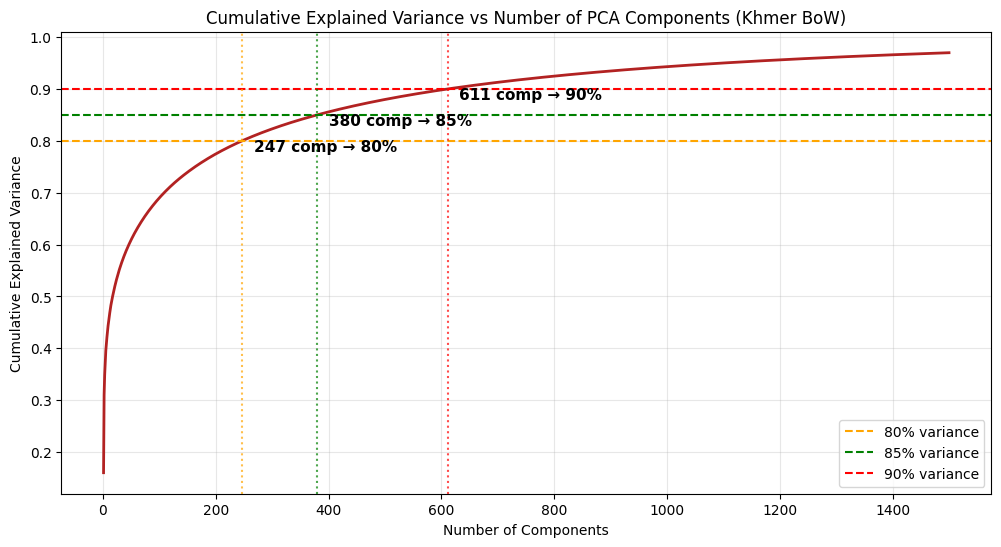

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import load_npz

# -----------------------------
# PCA (TruncatedSVD) Analysis
# -----------------------------
max_components = min(4000, X_train_bow.shape[1] - 1)  # limit to 3000 or n_features-1

# Use TruncatedSVD for sparse data
svd = TruncatedSVD(n_components=max_components, random_state=42)
svd.fit(X_train_bow)  # fit on training data only

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(svd.explained_variance_ratio_)

# -----------------------------
# Determine components for target variance
# -----------------------------
targets = [0.80, 0.85, 0.90]
optimal_ns = {}

print("="*60)
print("PCA COMPONENT ANALYSIS (TruncatedSVD for BoW)")
print("="*60)

for target in targets:
    n = np.argmax(cumulative_variance >= target) + 1
    optimal_ns[target] = n
    print(f"Components needed for >= {int(target*100)}% variance: {n} "
          f"(actual: {cumulative_variance[n-1]:.4f})")

# -----------------------------
# Plot cumulative variance
# -----------------------------
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(cumulative_variance[:1500]) + 1),
         cumulative_variance[:1500],
         color='firebrick', linewidth=2)

# Horizontal lines for target variance
plt.axhline(y=0.80, color='orange', linestyle='--', label='80% variance')
plt.axhline(y=0.85, color='green', linestyle='--', label='85% variance')
plt.axhline(y=0.90, color='red', linestyle='--', label='90% variance')

# Vertical lines showing number of components
for target, n in optimal_ns.items():
    if n <= 1500:
        plt.axvline(x=n, color={0.80:'orange', 0.85:'green', 0.90:'red'}[target],
                    linestyle=':', alpha=0.7)
        plt.text(n + 20, target - 0.02, f'{n} comp → {int(target*100)}%', 
                 fontsize=11, fontweight='bold')

plt.title("Cumulative Explained Variance vs Number of PCA Components (Khmer BoW)")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [52]:
# =========================================================
# Apply PCA to reduce dimensionality
# =========================================================
n_components = min(X_train_bow.shape[0], X_train_bow.shape[1], 380)

pca = PCA(n_components=n_components, random_state=42)

# Fit PCA on training set and transform all sets
X_train_pca = pca.fit_transform(X_train_bow.toarray())  # convert sparse to dense
X_val_pca   = pca.transform(X_val_bow.toarray())
X_test_pca  = pca.transform(X_test_bow.toarray())

print(f"PCA shape (train): {X_train_pca.shape}")
print(f"PCA shape (val):   {X_val_pca.shape}")
print(f"PCA shape (test):  {X_test_pca.shape}")

PCA shape (train): (5140, 380)
PCA shape (val):   (661, 380)
PCA shape (test):  (1543, 380)


## 2D Visualization of Class Separability

Explained variance (2D): 0.0428


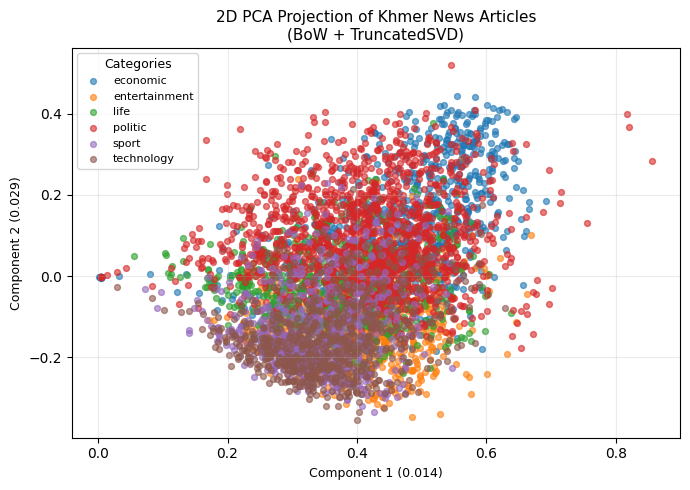

In [19]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
# -----------------------------
# Label mapping
# -----------------------------
LABEL_NAMES = {
    0: "economic",
    1: "entertainment",
    2: "life",
    3: "politic",
    4: "sport",
    5: "technology"
}

# -----------------------------
# Load BoW & labels
# -----------------------------
y_train = pd.read_csv(
    "../BOW_PROJECT/Bow_approach/labels/khmer_news_bow_train_labels.csv"
)["label"].values

# -----------------------------
# 1. Initialize PCA-like model (for sparse BoW)
# -----------------------------
svd_2d = TruncatedSVD(n_components=2, random_state=42)

# -----------------------------
# 2. Fit & Transform
# -----------------------------

X_train_norm = normalize(X_train_bow, norm="l2")
X_2d = svd_2d.fit_transform(X_train_norm)

print(f"Explained variance (2D): {svd_2d.explained_variance_ratio_.sum():.4f}")

# -----------------------------
# 3. Visualization (SMALLER FIGURE)
# -----------------------------
plt.figure(figsize=(7, 5))   # ⬅ smaller figure size

colors = [
    "#1f77b4",  # economic
    "#ff7f0e",  # entertainment
    "#2ca02c",  # life
    "#d62728",  # politic
    "#9467bd",  # sport
    "#8c564b"   # technology
]

for label_id, label_name in LABEL_NAMES.items():
    idx = y_train == label_id
    plt.scatter(
        X_2d[idx, 0],
        X_2d[idx, 1],
        label=label_name,
        alpha=0.6,
        s=18,              # ⬅ smaller points
        color=colors[label_id]
    )

# -----------------------------
# Labels & styling
# -----------------------------
plt.title(
    "2D PCA Projection of Khmer News Articles\n"
    "(BoW + TruncatedSVD)",
    fontsize=11
)
plt.xlabel(
    f"Component 1 ({svd_2d.explained_variance_ratio_[0]:.3f})",
    fontsize=9
)
plt.ylabel(
    f"Component 2 ({svd_2d.explained_variance_ratio_[1]:.3f})",
    fontsize=9
)

plt.legend(
    title="Categories",
    fontsize=8,
    title_fontsize=9,
    loc="best"
)

plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

## 3D Visualization of Class Separability

Explained variance ratio: [0.01379272 0.02901839 0.02578731]
Total explained variance: 0.06859842173841493


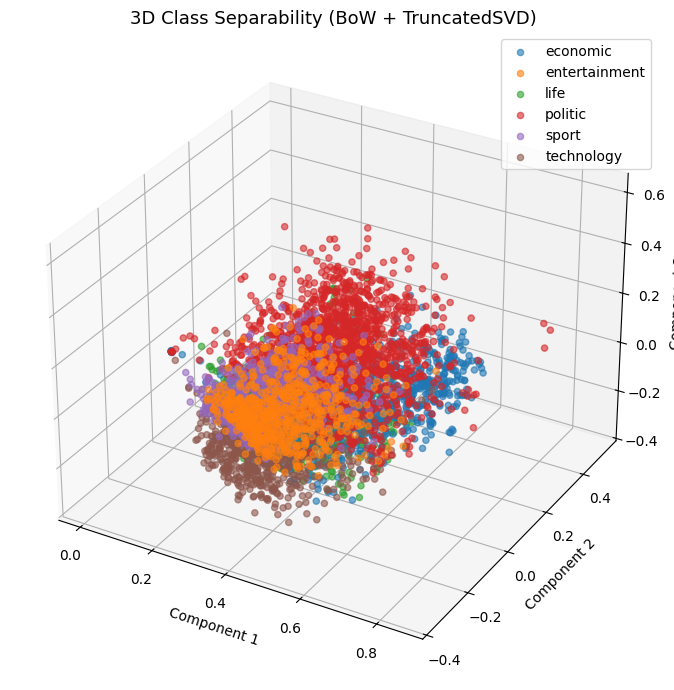

In [21]:
from mpl_toolkits.mplot3d import Axes3D
LABEL_NAMES = {
    0: "economic",
    1: "entertainment",
    2: "life",
    3: "politic",
    4: "sport",
    5: "technology"
}

y = pd.read_csv(
    "../BOW_PROJECT/Bow_approach/labels/khmer_news_bow_train_labels.csv"
)["label"].values

# Normalize BOW

X_bow_norm = normalize(X_train_bow, norm="l2")

# Reduce to 3D using TruncatedSVD

svd_3d = TruncatedSVD(n_components=3, random_state=42)
X_3d = svd_3d.fit_transform(X_bow_norm)

print("Explained variance ratio:", svd_3d.explained_variance_ratio_)
print("Total explained variance:", svd_3d.explained_variance_ratio_.sum())

# 3D Visualization

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection="3d")

for label_id, label_name in LABEL_NAMES.items():
    idx = np.where(y == label_id)
    ax.scatter(
        X_3d[idx, 0],
        X_3d[idx, 1],
        X_3d[idx, 2],
        label=label_name,
        alpha=0.6,
        s=20
    )

ax.set_title("3D Class Separability (BoW + TruncatedSVD)", fontsize=13)
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")

ax.legend()
plt.tight_layout()
plt.show()

## Train Classifiers with Class Imbalance Handling

In [31]:
# =========================================================
# Build classifiers function
# =========================================================
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier

def build_classifiers(random_state: int = 42):
    """
    Build a dictionary of classifiers for BoW + PCA text classification.

    Returns:
        dict: Dictionary containing initialized classifiers
    """
    models = {}

    # Logistic Regression
    lr = LogisticRegression(
        penalty="l2",
        C=0.8,
        solver="liblinear",
        max_iter=2000,
        class_weight="balanced",
        random_state=random_state
    )
    models["logistic"] = lr  # Single-label multi-class, no OneVsRest needed

    # Linear SVM
    svm = LinearSVC(
        C=0.1,
        loss="squared_hinge",
        class_weight="balanced",
        max_iter=3000,
        random_state=random_state
    )
    models["svm"] = svm

    # Random Forest
    rf = RandomForestClassifier(
        n_estimators=400,
        max_depth=25,
        min_samples_split=4,
        min_samples_leaf=2,
        class_weight="balanced",
        n_jobs=-1,
        random_state=random_state
    )
    models["random_forest"] = rf

    # XGBoost
    xgb = XGBClassifier(
        n_estimators=600,
        learning_rate=0.07,
        max_depth=6,
        subsample=0.85,
        colsample_bytree=0.85,
        objective="multi:softmax",   # <-- use multi-class softmax
        num_class=6,                 # <-- number of classes
        eval_metric="mlogloss",
        tree_method="hist",
        n_jobs=-1,
        random_state=random_state
    )
    models["xgboost"] = xgb

    return models

In [32]:
# =========================================================
# Train and evaluate classifiers with PCA
# =========================================================
from sklearn.metrics import f1_score, classification_report

label_cols = ['economic', 'entertainment', 'life', 'politic', 'sport', 'technology']
results = {}

print("\nTraining and evaluating models (BoW + PCA)...\n")

classifiers = build_classifiers(random_state=42)

for model_name, model in classifiers.items():
    print(f"→ Training {model_name}...")

    # Fit model on PCA-reduced training data
    model.fit(X_train_pca, y_train)

    # Predict on validation set
    y_pred = model.predict(X_val_pca)

    # Compute macro F1 score
    macro_f1 = f1_score(y_val, y_pred, average="macro", zero_division=0)
    results[model_name] = macro_f1

    # Print classification report
    print(f"{model_name} — Validation Macro F1: {macro_f1:.4f}")
    print(classification_report(
        y_val,
        y_pred,
        target_names=label_cols,
        zero_division=0
    ))
    print("-" * 60)

# =========================================================
# Summary of results
# =========================================================
print("\nValidation Macro F1 scores for all models:")
for model_name, score in results.items():
    print(f"{model_name}: {score:.4f}")


Training and evaluating models (BoW + PCA)...

→ Training logistic...


C:\Users\Kimlang\AppData\Roaming\Python\Python314\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


logistic — Validation Macro F1: 0.8816
               precision    recall  f1-score   support

     economic       0.89      0.87      0.88       109
entertainment       0.89      0.91      0.90        90
         life       0.73      0.76      0.74        90
      politic       0.94      0.96      0.95       192
        sport       0.97      0.98      0.97        90
   technology       0.89      0.80      0.84        90

     accuracy                           0.89       661
    macro avg       0.88      0.88      0.88       661
 weighted avg       0.89      0.89      0.89       661

------------------------------------------------------------
→ Training svm...
svm — Validation Macro F1: 0.8845
               precision    recall  f1-score   support

     economic       0.88      0.88      0.88       109
entertainment       0.90      0.93      0.92        90
         life       0.76      0.77      0.76        90
      politic       0.93      0.95      0.94       192
        sport      

Plotting confusion matrices using: svm


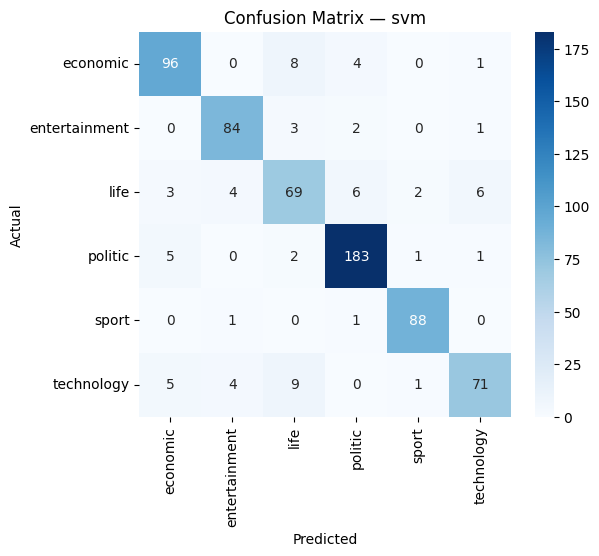

In [33]:
# Best model based on macro F1
best_model_name = max(results, key=results.get)
best_clf = classifiers[best_model_name]

# Predict on validation set
y_pred_best = best_clf.predict(X_val_pca)
y_val_array = np.array(y_val)  # ensure numpy array
y_pred_array = np.array(y_pred_best)

print(f"Plotting confusion matrices using: {best_model_name}")
# Ensure y_val and y_pred are 1D arrays
y_val_array = np.array(y_val)
y_pred_best = best_clf.predict(X_val_pca)

# Confusion matrix for the best model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val_array, y_pred_best)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_cols,
    yticklabels=label_cols
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix — {best_model_name}")
plt.show()

In [65]:
# =========================================================
# Save models and preprocessing objects
# =========================================================
from joblib import dump
import os
import pandas as pd

# -----------------------------
# 0. Directory to save everything
# -----------------------------
save_dir = '../BOW_PROJECT/models/bow_models_with_pca'
os.makedirs(save_dir, exist_ok=True)

# -----------------------------
# 1. Save each trained classifier
# -----------------------------
dump(classifiers["logistic"], os.path.join(save_dir, 'logistic_regression_model.joblib'))
dump(classifiers["svm"], os.path.join(save_dir, 'linear_svm_model.joblib'))
dump(classifiers["random_forest"], os.path.join(save_dir, 'random_forest_model.joblib'))
dump(classifiers["xgboost"], os.path.join(save_dir, 'xgboost_model.joblib'))


# -----------------------------
# 2. Save preprocessing objects
# -----------------------------

# Save the PCA object used to create X_train_pca
dump(pca, os.path.join(save_dir, 'pca.joblib'))

# -----------------------------
# 3. Save class labels (for inference)
# -----------------------------
pd.DataFrame(label_cols, columns=["label"]).to_csv(os.path.join(save_dir, 'classes.csv'), index=False)

print("✅ Models, preprocessors, and class labels saved successfully!")

✅ Models, preprocessors, and class labels saved successfully!


In [ ]:
# !pip install khmer-nltk -q

In [37]:
from khmernltk import word_tokenize
from nltk.corpus import stopwords
english_stopwords = set(stopwords.words('english'))

In [ ]:
import re
import numpy as np
import pandas as pd
from joblib import load

# -----------------------------
# 1. Load saved objects
# -----------------------------
count_vec = load('../BOW_PROJECT/Bow_approach/khmer_news_bow_vectorizer.pkl')
pca       = load('../BOW_PROJECT/models/bow_models_with_pca/pca.joblib')
model     = load('../BOW_PROJECT/models/bow_models_with_pca/linear_svm_model.joblib')
classes   = pd.read_csv('../BOW_PROJECT/models/bow_models_with_pca/classes.csv')['label'].tolist()

# -----------------------------
# 2. Preprocessing functions
# -----------------------------
def clean_khmer_text(text: str) -> str:
    if not isinstance(text, str):
        return ""

    text = re.sub(r'<[^>]+>', '', text)                    # remove HTML
    text = re.sub(r'[\u200B-\u200D\uFEFF]', '', text)      # zero-width chars
    text = re.sub(
        r'[!"#$%&\'()*+,—./:;<=>?@[\]^_`{|}~។៕៖ៗ៘៙៚៛«»-]',
        ' ',
        text
    )
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def khmer_tokenize(text: str) -> str:
    """
    Clean and tokenize Khmer text using khmer-nltk.
    Output is a SPACE-separated token string
    (required for CountVectorizer(analyzer=str.split))
    """
    cleaned = clean_khmer_text(text)
    if not cleaned:
        return ""

    tokens = word_tokenize(cleaned, return_tokens=True)

    # filter empty tokens
    tokens = [tok for tok in tokens if tok.strip()]

    return " ".join(tokens)


# -----------------------------
# 3. Prediction function
# -----------------------------
def predict_khmer_text(text: str):
    # 1. Preprocess
    tokenized_text = khmer_tokenize(text)
    if not tokenized_text:
        return "No valid text to predict"

    # 2. BoW
    bow_vec = count_vec.transform([tokenized_text])

    # 3. PCA
    bow_pca = pca.transform(bow_vec.toarray())

    # 4. Predict (MULTI-CLASS)
    pred = model.predict(bow_pca)   # shape: (1,)

    class_index = int(pred[0])
    return classes[class_index]


# -----------------------------
# 4. Test
# -----------------------------
new_text = "រដ្ឋាភិបាលជប៉ុន សូមស្វាគមន៍លទ្ធផលកិច្ចប្រជុំគណៈកម្មាធិការព្រំដែនទូទៅរវាងកម្ពុជា និងថៃ ដែលបានធ្វើឡើងនៅម៉ាឡេស៊ី នៅថ្ងៃទី២៣ ខែតុលា។ នេះបើតាមសេចក្តីថ្លែងការណ៍របស់លោក Kitamura Toshihiro អ្នកនាំពាក្យក្រសួងការបរទេសជប៉ុន។"

predicted_category = predict_khmer_text(new_text)
print("Predicted category:", predicted_category)

Predicted category: politic


In [79]:
print(khmer_tokenize(new_text))

រដ្ឋាភិបាល ជប៉ុន សូមស្វាគមន៍ លទ្ធផល កិច្ចប្រជុំ គណៈកម្មាធិការ ព្រំដែន ទូទៅ រវាង កម្ពុជា និង ថៃ ដែល បាន ធ្វើឡើង នៅ ម៉ាឡេស៊ី នៅ ថ្ងៃទី ២៣ ខែតុលា នេះ បើ តាម សេចក្តីថ្លែងការណ៍ របស់ លោក Kitamura Toshihiro អ្នកនាំពាក្យ ក្រសួង ការបរទេស ជប៉ុន


In [60]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kimlang\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kimlang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True